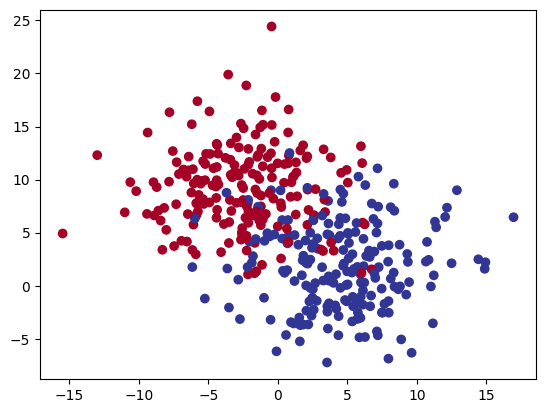

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=400, n_features=2, centers=2, cluster_std=4, random_state=42
)

plt.scatter(X.transpose()[0], X.transpose()[1], c=y, cmap="RdYlBu")
plt.show()

In [12]:
print(f"Length of X: {len(X)}")
print(f"Length of y: {len(y)}")

Length of X: 400
Length of y: 400


In [13]:
train_size = int(len(X) * 0.8)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [14]:
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_test: {len(X_test)}")

Length of X_train: 320
Length of X_test: 80


We need to have:

Root Node: Initial node of the Decision Tree

Decision Node: Nodes are defined by an attribute of the data and the threshold where we split data. These nodes are the decisions in the tree.

Leaf Nodes: Nodes that are the final node in the tree and return the classification

For each step, go through all attributes and thresholds to find minimized entropy.

Once we split the data into leaf nodes, perform recursion to on each leaf node

Assuming y = {0, 1}



In [15]:
# Terminal node
class LeafNode:
    def __init__(self, X, y, pred):
        self.X = X
        self.y = y
        self.pred = pred

In [16]:
# Make a Binary Decision Tree class
class DecisionNode:
    def __init__(self):
        self.left = None
        self.right = None

        self.best_feature = 0
        self.best_thres = 0
        self.best_entropy = 1

        self.do_not_use = False

    def entropy(self, y):
        # Get the positive probability by getting the sum of all the 1s classes (binary classification)
        if not y or len(y) == 0 or len(set(y)) == 1:
            return 0

        pos_prob = float(sum(y) / len(y))
        neg_prob = 1 - pos_prob

        with np.errstate(divide="ignore", invalid="ignore"):
            result = -pos_prob * np.log2(pos_prob) - neg_prob * np.log2(neg_prob)

        return result

    def fit(self, X, y):
        # Iterate through all X features
        # Iterate through all thresholds (X values)
        # Find the best attribute and threshold minimizing entropy
        x_t = X.transpose()

        for feature_idx in range(len(x_t)):
            for test_thres in x_t[feature_idx]:
                # split the data by threshold
                # with the 2 split datasets
                # calculate entropy for each
                split_left = []
                split_right = []

                split_x_left = []
                split_x_right = []

                # For every element in X and y, put it in the correct bucket based on the threshold
                for one_x, one_y in zip(X, y):
                    if one_x[feature_idx] >= test_thres:
                        split_left.append(one_y)
                        split_x_left.append(one_x)
                    else:
                        split_right.append(one_y)
                        split_x_right.append(one_x)

                entropy_left = self.entropy(split_left)
                entropy_right = self.entropy(split_right)
                # Use a weighted sum for the total entropy
                total_entropy = (len(split_left) / len(y)) * entropy_left + (
                    len(split_right) / len(y)
                ) * entropy_right

                # Update if the entropy is lower
                if self.best_entropy > total_entropy:
                    self.best_entropy = total_entropy
                    self.best_thres = test_thres
                    self.best_feature = feature_idx

                    # Create the left and right splits
                    if len(split_left) > 0:
                        left = 1 if sum(split_left) / len(split_left) > 0.5 else 0
                        self.setLeft(
                            node=LeafNode(np.array(split_x_left), split_left, left)
                        )

                    if len(split_right) > 0:
                        right = 1 if sum(split_right) / len(split_right) > 0.5 else 0
                        self.setRight(
                            node=LeafNode(np.array(split_x_right), split_right, right)
                        )

        if len(split_left) == 0 or len(split_right) == 0:
            self.do_not_use = True
            print("Bad decision node. Do not use")
            return

        print(
            f"Best Feature: {self.best_feature} | Best Threshold: {self.best_thres} | Best Entropy: {self.best_entropy}"
        )

    def setLeft(self, node):
        self.left = node

    def setRight(self, node):
        self.right = node

FIT
Base cases

check if current depth > max_depth
min entropy
no entropy
Arms

figure out best threshold variable
Split data set with result
Create decision nodes for them
State

current depth
store results (threshold and variable) somewhere
store the splits

In [17]:
class ID3DecisionTree:
    def __init__(self, max_depth: int = None):
        self.root = None
        self.max_depth = max_depth

    def fit(self, X, y):
        self.root = self.recursion_fit(X, y, 0, None)

    def recursion_fit(self, X, y, depth, parent):
        if depth >= self.max_depth:
            return None

        decision_node = DecisionNode()
        decision_node.fit(X, y)

        if decision_node.do_not_use:
            return None

        left_node = None
        right_node = None

        if decision_node.left is not None:
            left_node = self.recursion_fit(
                decision_node.left.X, decision_node.left.y, depth + 1, decision_node
            )
            if left_node is not None:
                decision_node.setLeft(left_node)

        if decision_node.right is not None:
            right_node = self.recursion_fit(
                decision_node.right.X, decision_node.right.y, depth + 1, decision_node
            )
            if right_node is not None:
                decision_node.setRight(right_node)

        return decision_node

    def single_predict(self, x, parent):
        if parent is None:
            return None

        if isinstance(parent, LeafNode):
            return parent.pred

        if x[parent.best_feature] >= parent.best_thres:
            return self.single_predict(x, parent.left)
        else:
            return self.single_predict(x, parent.right)

    def predict(self, X):
        return_vals = []
        for x in X:
            return_vals.append(self.single_predict(x, self.root))

        return return_vals

    def print_graph():
        # https://graphviz.readthedocs.io/en/stable/manual.html
        pass

In [18]:
model = ID3DecisionTree(max_depth=5)
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

print(y_preds)

test_acc = np.mean(y_preds == y_test)
print(f"Test Accuracy: {test_acc:.6f}")

Best Feature: 1 | Best Threshold: 5.004168669647086 | Best Entropy: 0.6229329787203692
Best Feature: 0 | Best Threshold: 3.61996996654468 | Best Entropy: 0.44541835774399485
Best Feature: 1 | Best Threshold: 10.634212972042144 | Best Entropy: 0.3820842903742652
Bad decision node. Do not use
Best Feature: 1 | Best Threshold: 6.030649944013254 | Best Entropy: 0.18998107760193744
Best Feature: 0 | Best Threshold: 4.6079882709616315 | Best Entropy: 0.0
Best Feature: 1 | Best Threshold: 5.9448958766461235 | Best Entropy: 0.0
Best Feature: 1 | Best Threshold: 9.288538027422431 | Best Entropy: 0.2973903739220721
Best Feature: 0 | Best Threshold: -0.4490068778285585 | Best Entropy: 0.0
Best Feature: 0 | Best Threshold: -0.4490068778285585 | Best Entropy: 0.0
Best Feature: 0 | Best Threshold: -2.457190055541122 | Best Entropy: 0.0
Best Feature: 0 | Best Threshold: -3.687838795306787 | Best Entropy: 0.5368411261843896
Best Feature: 1 | Best Threshold: 6.185781097272346 | Best Entropy: 0.71707685

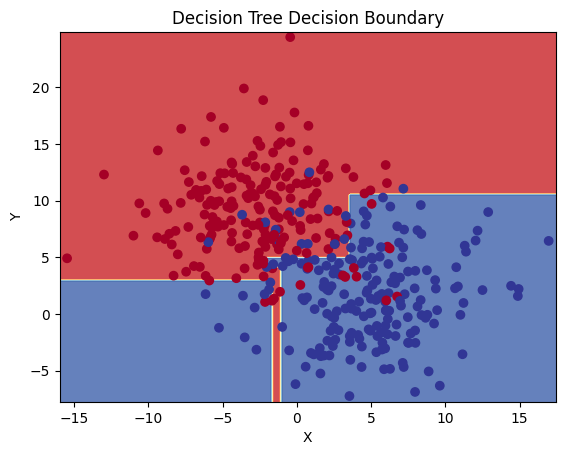

In [19]:
h = 0.2

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z_numeric = np.array([0 if v is None else v for v in Z]).reshape(xx.shape)

plt.contourf(xx, yy, Z_numeric, cmap=plt.cm.RdYlBu, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Decision Tree Decision Boundary")
plt.show()